In [117]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np
import cv2
import os
import random
import pickle
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

### Code block used to obtain camera calibration and distortion coefficient

In [118]:
class Camera(object):

    def __init__(self, images, g_size=(9,6)):
        self.mtx = None
        self.dist = None
        self.corrected_imgs = []
        self.original_imgs = []
        self.err_imgs = []
        self.get_mtx_dist_coeff(images, g_size)

    def __call__(self, image):
        if self.mtx is not None and self.dist is not None:
            return cv2.undistort(image, self.mtx, self.dist, None, self.mtx)
        else:
            return image

    def get_mtx_dist_coeff(self, images, g_size):
        pts = np.zeros((g_size[1] * g_size[0], 3), np.float32)
        pts[:, :2] = np.mgrid[0:g_size[0], 0:g_size[1]].T.reshape(-1, 2)
        obj_points = [] # points in real world image
        image_points = []  # points in image plane
        img_size = None

        # Loop through the images looking for chessboard corners
        for i, path in enumerate(images):
            image = mpimg.imread(path)
            self.original_imgs.append(mpimg.imread(path))
            # convert to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            
            # Finding chessboard corners
            f, corners = cv2.findChessboardCorners(gray, g_size, None)
         
            if f:
                obj_points.append(pts)
                image_points.append(corners)
                img_size = (image.shape[1], image.shape[0])
                # Drawing detected corners on an image
                cv2.drawChessboardCorners(image, g_size, corners, True)
                self.corrected_imgs.append(image)
            else:
                self.err_imgs.append(image)

        # Camera calibration, given object points, image points, and the shape of the grayscale image
        if obj_points and image_points:
            _, self.mtx, self.dist, _, _ = cv2.calibrateCamera(obj_points, image_points,img_size, None, None)


## Gradient thresholding flow

In [119]:
def abs_sobel_thresh_mask(image, axis='x', sobel_ksize=3, threshold=(0, 255)):
  
    if axis == 'x':
        sobel = np.absolute(cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_ksize))
    elif axis == 'y':
        sobel = np.absolute(cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_ksize))
    else:
        raise 'Invalid value for axis: {}'.format(axis)

    mask = scaled_img_mask(sobel, threshold)
    return mask

def mag_grad_mask(image, sobel_ksize=3, threshold=(0, 255)):
    x, y   = compute_gradients(image, sobel_ksize)
    magnit = np.sqrt(x**2 + y**2)
    mask   = scaled_img_mask(magnit, threshold)
    return mask

def dir_grad_mask(image, sobel_ksize=3, threshold=(0, 255)):
    x, y   = compute_gradients(image, sobel_ksize)
    direct = np.arctan2(np.absolute(y), np.absolute(x))
    mask   = color_mask_thresholding(direct, threshold=threshold)
    return mask

def compute_gradients(image, sobel_ksize):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_ksize)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_ksize)
    return sobelx, sobely

## Color thresholding flow

In [120]:

def scaled_img_mask(image, threshold):
    # Scale to 8 bit
    img  = np.uint8(255*image / np.max(image))
    mask = color_mask_thresholding(img, threshold=threshold)
    return mask

def get_schannel_features(image):
    # Converting to HLS color space
    hls = cv2.cvtColor(np.copy(image), cv2.COLOR_RGB2HLS).astype(np.float)
    # Extract the S channel
    s_channel = hls[:, :, 2]
    # Obtain gradient magnitude, direction and absolute gradient mask in the x and y direction
    gradx = abs_sobel_thresh_mask(s_channel, axis='x', threshold=(20, 100))
    grady = abs_sobel_thresh_mask(s_channel, axis='y', threshold=(20, 100))
    mag = mag_grad_mask(s_channel, threshold=(20, 100)) 
    directn = dir_grad_mask(s_channel, threshold=(0.7, 1.3)) 
    grad_mask = np.zeros_like(s_channel)
    grad_mask[((gradx == 1) & (grady == 1)) | ((mag == 1) & (directn == 1))] = 1

    color_mask = color_mask_thresholding(s_channel, threshold=(170, 255))
    return color_mask, grad_mask, s_channel


def color_mask_thresholding(img, threshold=(0, 255)):
 
    mask = np.zeros_like(img)
    mask[(img >= threshold[0]) & (img <= threshold[1])] = 1
    return mask

## Combined Thresholding

In [121]:
def combined_binary_thresh(image):
    color_mask, grad_mask, _ = get_schannel_features(image)
    
    mask = np.zeros_like(grad_mask)
    mask[(grad_mask == 1) | (color_mask == 1)] = 1
    return mask

def colord_binary_thresh(image):
    color_mask, grad_mask, s_channel = get_schannel_features(image)
    
    return np.dstack((np.zeros_like(s_channel), grad_mask, color_mask))

In [122]:
# We identified four trapezoidal shaped source points where the lane lines are straight, and found four lines that after
# perspective transform made the lines look straight and vertical from a bird's eye view perspective. With the source 
# points defined, we assumed the road was flat, the camera perspective remain unchanged and applied it to new images.


def perspective_transform(image):
    height = image.shape[0]
    width = image.shape[1]
    src1 = [width // 2 - 76, height * 0.625]
    src2 = [width // 2 + 76, height * 0.625]
    src3 = [-100, height]
    src4 = [width + 100, height]
    src = np.float32([src1,src2,src3,src4])
    dst1 = [100, 0]
    dst2 = [width - 100, 0]
    dst3 = [100, height]
    dst4 = [width - 100, height]
    dst = np.float32([dst1,dst2,dst3,dst4])
#     print("src:", src)
#     print("dst:", dst)
    t_mtx = cv2.getPerspectiveTransform(src, dst)
    warped_img = cv2.warpPerspective(image, t_mtx, (width, height))
    unwarp_img= cv2.getPerspectiveTransform(dst, src)
    return (warped_img, unwarp_img)




In [123]:
class SlidingWindow(object):
    """Used to search and determine hot pixels (potential lane lines) within defined window parameters"""
    

    def __init__(self, y_high, y_lxow, x_center, margin=100, minpix=50):
        self.x = x_center
        self.x_mean = x_center
        self.y_lxow = y_lxow
        self.y_high = y_high
        self.margin = margin
        self.minpix = minpix

    def nonzero_pixels_indices(self, nonzero, win_x=None):
        if win_x is not None:
            self.x = win_x 
        
        win_inds = ((nonzero[0] >= self.y_lxow) & 
                    (nonzero[0] < self.y_high) & 
                    (nonzero[1] >= self.x - self.margin) &
                    (nonzero[1] < self.x + self.margin)).nonzero()[0]

        if len(win_inds) > self.minpix: 
            self.x_mean = np.int(np.mean(nonzero[1][win_inds]))
        else:
            self.x_mean = self.x

        return win_inds

    def construct_window(self):
        x1 = self.x - self.margin
        y1 = self.y_lxow
        x2 = self.x + self.margin
        y2 = self.y_high
        return ((x1, y1), (x2, y2))

In [124]:
from collections import deque

class LaneLine(object):
    
    """ Used to:
        - fit the lane lines
        - generate subsequent data from their fits
        - estimate the lane line curvature
        - estimate the distance of the car from the lane center
        """
    def __init__(self, x, y, height, width):
        self.height = height
        self.width = width
        self.coef = deque(maxlen=5)
        self.fit_points(x, y)
        self._pixels_per_x_axis = 700
        self._pixels_per_y_axis = 720
     
        self._lane_width = 3.7 
        self._image_lane_length = 30 
        
    def fit_points(self, x, y):
        points  = len(y) > 0 and (np.max(y) - np.min(y)) > self.height * 0.625 
        empty_ = len(self.coef) == 0
        
        if points or empty_:
            self.coef.append(np.polyfit(y, x, 2))

    def generate_data(self):
        y = np.linspace(0, self.height - 1, self.height)
        fit = np.array(self.coef).mean(axis=0)
        
        return np.stack((fit[0] * y ** 2 + fit[1] * y + fit[2], y)).astype(np.int).T

    def measure_curvature_real(self):

        ym_per_pix = self._image_lane_length / self._pixels_per_y_axis 
        xm_per_pix = self._lane_width / self._pixels_per_x_axis
        
        points = self.generate_data()
        x = points[:, 0]
        y = points[:, 1]
        fit_cr = np.polyfit(y * ym_per_pix, x * xm_per_pix, 2)
        first_deriv = 2 * fit_cr[0] * self._pixels_per_y_axis * ym_per_pix + fit_cr[1]
        secnd_deriv = 2 * fit_cr[0]
        radius = int(((1 + (first_deriv ** 2) ** 1.5) / np.absolute(secnd_deriv)))
        return radius
    
    def camera_distance(self):
        xm_per_pix = self._lane_width / self._pixels_per_x_axis
        
        points = self.generate_data()
        x = points[np.max(points[:, 1])][0]
        distance = np.absolute((self.width // 2 - x) * xm_per_pix)
        return distance
    

In [127]:
class Pipeline(object):
    
    def __init__(self, img, nwindows=9):
        self.height = img.shape[0]
        self.width = img.shape[1]
        self.nwindows = nwindows
        self.left_lane = None
        self.right_lane = None
        self.left_wins = []
        self.right_wins = []
        self.draw_initial_lane_lines(img)
        
    def draw_initial_lane_lines(self, frame):
        edges = combined_binary_thresh(frame)
        transformed_egdes, _ = perspective_transform(edges)
        
        histogram = np.sum(transformed_egdes[int(self.height / 2):, :], axis=0)
        nonzero = transformed_egdes.nonzero()

        left_lane_inds = np.empty([0], dtype=np.int)
        right_lane_inds = np.empty([0], dtype=np.int)

        window_height = int(self.height / self.nwindows)
        
        for i in range(self.nwindows):
    
            if len(self.left_wins) > 0:
                l_x_center = self.left_wins[-1].x
                r_x_center = self.right_wins[-1].x
            else:
                l_x_center = np.argmax(histogram[:self.width // 2])
                r_x_center = np.argmax(histogram[self.width // 2:]) + self.width // 2
                    
            left_win = SlidingWindow(y_high=self.height - i * window_height, 
                                     y_lxow=self.height - (i + 1) * window_height, 
                                     x_center=l_x_center)
            
            right_win = SlidingWindow(y_high=self.height - i * window_height, 
                                      y_lxow=self.height - (i + 1) * window_height, 
                                      x_center=r_x_center)
            

            left_lane_inds = np.append(left_lane_inds, left_win.nonzero_pixels_indices(nonzero), axis=0)
            right_lane_inds = np.append(right_lane_inds, right_win.nonzero_pixels_indices(nonzero), axis=0)
            self.left_wins.append(left_win)
            self.right_wins.append(right_win)
            
        self.left_lane = LaneLine(nonzero[1][left_lane_inds], nonzero[0][left_lane_inds], 
                                  self.height, self.width)
        self.right_lane = LaneLine(nonzero[1][right_lane_inds], nonzero[0][right_lane_inds], 
                                  self.height, self.width)
        
    def compute_non_zeros(self, frame, windows):
        indices = np.empty([0], dtype=np.int)
        nonzero = frame.nonzero()
        win_x = None
        
        for win in windows:
            indices = np.append(indices, win.nonzero_pixels_indices(nonzero, win_x), axis=0)
            win_x = win.x_mean
            
        return (nonzero[1][indices], nonzero[0][indices])
    
    def highlight_lane(self, image, unwrap_m=None):
        overlay = np.zeros_like(image).astype(np.uint8)
        points = np.vstack((self.left_lane.generate_data(), 
                            np.flipud(self.right_lane.generate_data())))
        cv2.fillPoly(overlay, [points], (0, 255, 0))
        
        if unwrap_m is not None:
            overlay = cv2.warpPerspective(overlay, unwrap_m, (image.shape[1], image.shape[0]))
            
        alpha = 0.6
        return cv2.addWeighted(image, alpha, overlay, 1 - alpha, 0)
   
    
    def driving_info_overlay(self, frame):
        if len(frame.shape) == 2:
            image = np.dstack((frame, frame, frame))
        else:
            image = frame
            
        for win in self.left_wins:
            vertices = win.construct_window()
            cv2.rectangle(image, vertices[0], vertices[1], (1.0, 1.0, 0), 2)
            
        for win in self.right_wins:
            vertices = win.construct_window()
            cv2.rectangle(image, vertices[0], vertices[1], (1.0, 1.0, 0), 2)
            
        cv2.polylines(image, [self.left_lane.generate_data()], False, (1.0, 1.0, 0), 2)
        cv2.polylines(image, [self.right_lane.generate_data()], False, (1.0, 1.0, 0), 2)
        
        return image * 255
    
    def radius_of_curvature(self):
        radius = int(np.average([self.left_lane.measure_curvature_real(), 
                                 self.right_lane.measure_curvature_real()]))
        return radius
    
    def inscribe_text(self, frame, text, x, y):
        cv2.putText(frame, text, (x, y), cv2.FONT_HERSHEY_DUPLEX, 0.8, (255, 255, 255), 2)
    
    def create_all(self, frame):
        edges = combined_binary_thresh(frame)
        transformed_egdes, unwrap_m = perspective_transform(edges) 

        (left_x, left_y) = self.compute_non_zeros(transformed_egdes, self.left_wins)
        self.left_lane.fit_points(left_x, left_y)

        (right_x, right_y) = self.compute_non_zeros(transformed_egdes, self.right_wins)
        self.right_lane.fit_points(right_x, right_y)
        
        edges = colord_binary_thresh(frame)
        info_overlay = self.driving_info_overlay(perspective_transform(edges)[0])
        top_overlay  = self.highlight_lane(perspective_transform(frame)[0])
        info_overlay = cv2.resize(info_overlay, (0,0), fx=0.3, fy=0.3)
        top_overlay  = cv2.resize(top_overlay, (0,0), fx=0.3, fy=0.3)
        frame[:250, :, :] = frame[:250, :, :] * 0.4
        (height, width, _) = info_overlay.shape        
        frame[25:25 + height, 25:25 + width, :] = info_overlay
        frame[25:25 + height, 25 + 25 + width:25 + 25 + width + width, :] = top_overlay
        text_x = 25 + 25 + width + width + 25
        
        lane_width = self.left_lane.camera_distance() + self.right_lane.camera_distance() 
        off_center = self.right_lane.camera_distance() - lane_width / 2
        self.inscribe_text(frame, 'Distance off center:    {:.1f} m'.format(off_center), text_x, 80)
        self.inscribe_text(frame, 'Radius of curvature:  {} m'.format(self.radius_of_curvature()), text_x, 140)
        
        frame = self.highlight_lane(frame, unwrap_m)
        
        return frame

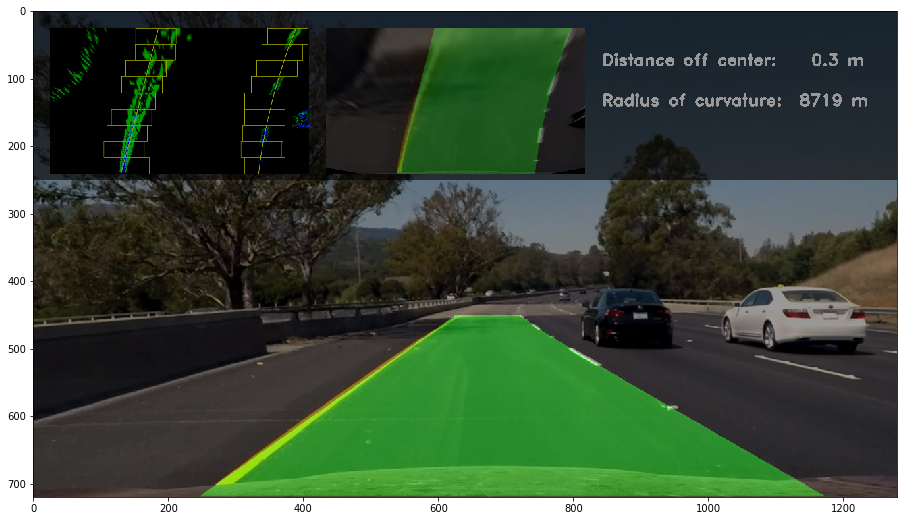

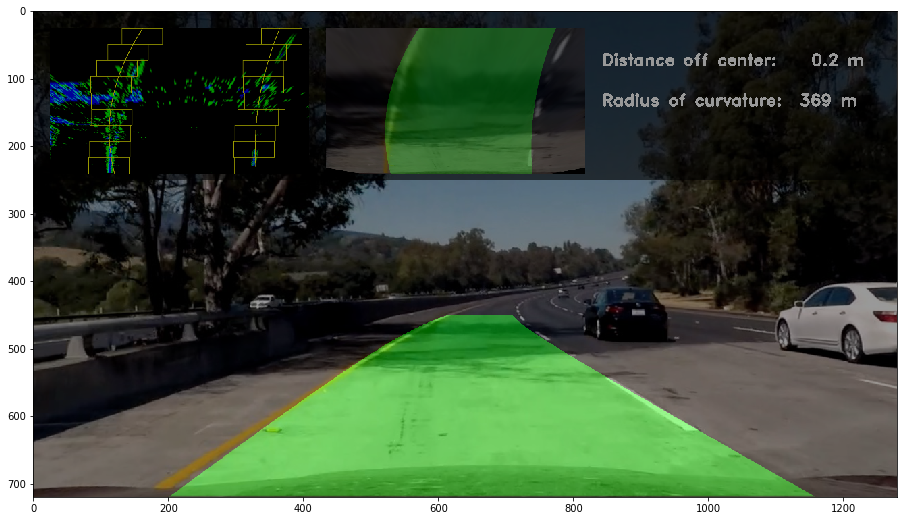

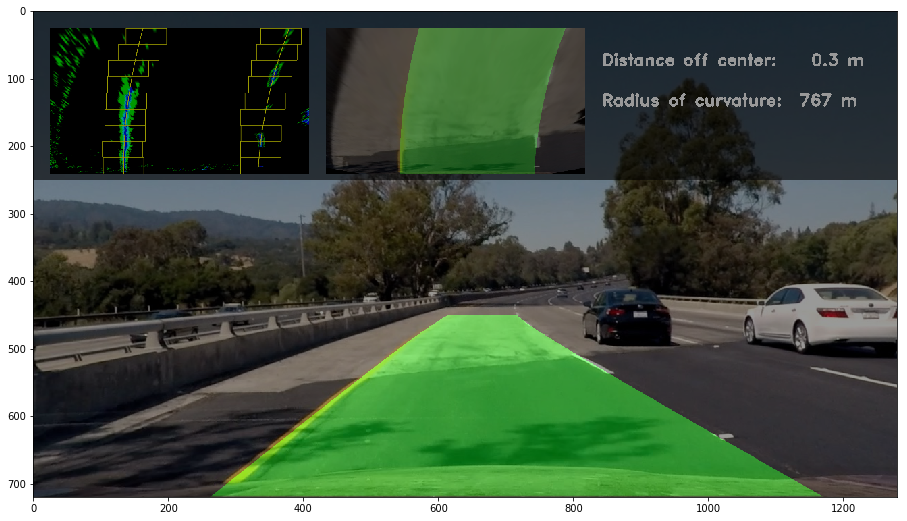

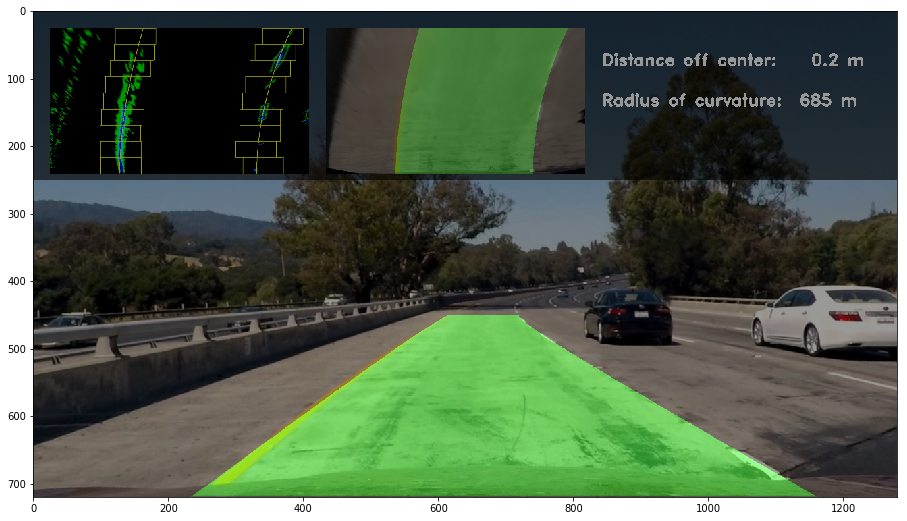

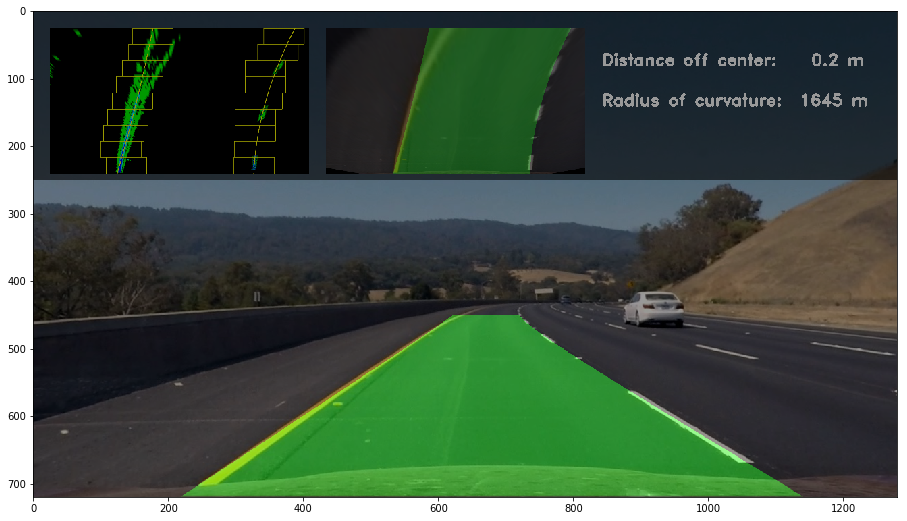

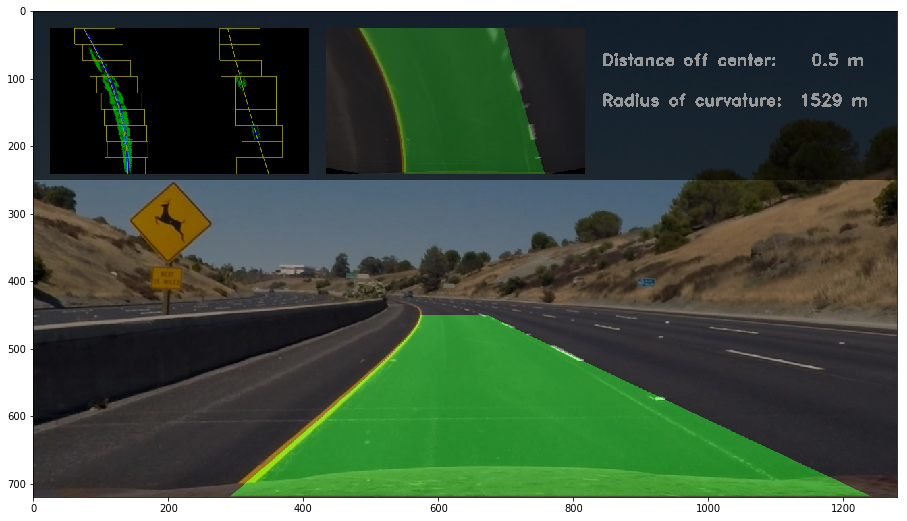

In [130]:

undistorted_imgObj = Camera(glob.glob('camera_cal/calibration*.jpg'))

for image_path in glob.glob('test_images/test*.jpg'):
    image = mpimg.imread(image_path)
    calibrated = undistorted_imgObj(image) 
    pipeline = Pipeline(calibrated)
    overlay = pipeline.create_all(calibrated)
    
    mpimg.imsave(image_path.replace('test_images', 'output_images'), overlay)
    plt.figure(figsize=(12, 12))
    plt.imshow(overlay)
    plt.subplots_adjust(left=0.0, right=1, top=0.9, bottom=0.0)
    plt.show()

In [131]:
from moviepy.editor import VideoFileClip

def apply_pipeline(video_path_prefix):
    output_video_name = 'videos/{}_updated.mp4'.format(video_path_prefix)
    input_video = VideoFileClip("./{}.mp4".format(video_path_prefix))

    calibrated = undistorted_imgObj(input_video.get_frame(0)) 
    pipeline = Pipeline(calibrated)

    output_video = input_video.fl_image(pipeline.create_all)

    %time output_video.write_videofile(output_video_name, audio=False)

In [132]:
apply_pipeline('project_video')

[MoviePy] >>>> Building video videos/project_video_updated.mp4
[MoviePy] Writing video videos/project_video_updated.mp4


100%|█████████▉| 1260/1261 [06:19<00:00,  3.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/project_video_updated.mp4 

CPU times: user 12min 36s, sys: 7.5 s, total: 12min 43s
Wall time: 6min 20s


In [133]:
apply_pipeline('challenge_video')

[MoviePy] >>>> Building video videos/challenge_video_updated.mp4
[MoviePy] Writing video videos/challenge_video_updated.mp4


100%|██████████| 485/485 [02:35<00:00,  3.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/challenge_video_updated.mp4 

CPU times: user 4min 59s, sys: 10.4 s, total: 5min 9s
Wall time: 2min 35s
